# Reactive covering

## Introduction

EXPLAIN

In [1]:
from matplotlib import pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cf
import math
from docplex.mp.model import Model

import random
import json

def showSolution(data,solution):
    
    # print the booking strategy
    print("Bookings:")
    for booking in solution['Bookings']:
        print(booking)

    # show the passes
    minVisiDuration = data['minVisiDuration']
    AOIs = data['AOIs']
    nAOIs = len(AOIs)
    accesses = data['Accesses']
    satPasses = data['Passes']
    nPasses = len(satPasses)
    
    ncols = 3
    nrows = math.ceil(nPasses / ncols)
    proj = ccrs.PlateCarree()
    fig, axs = plt.subplots(nrows=nrows,ncols=ncols, subplot_kw={'projection': proj},figsize=(30,80))
    axs = axs.flatten()

    for i in range(nPasses):
        satPass = satPasses[i]
        ax = axs[i]
        ax.set_extent([-15, 25, 35, 60])
        ax.stock_img()
        ax.add_feature(cf.COASTLINE, lw=1)
        ax.add_feature(cf.BORDERS)
        #plt.gcf().set_size_inches(15, 15)    
        for aoi in  AOIs:
            ax.plot([aoi['lon']], [aoi['lat']], 'kx')
        ax.set_title("Pass #{} [{},{}]".format(i,satPass['startDate'],satPass['endDate']))
    
        booking = None
        for bk in solution['Bookings']:
            if bk['passId'] == i:
                booking = bk            
                break
        
        for accessId in satPass['accessIds']:
            access = accesses[accessId]
            aoi = AOIs[access['aoiId']]            
            ax.plot([aoi['lon']], [aoi['lat']], 'rx')
            # show the reservations
            if (booking != None) and (booking['bookingStart'] <= access['end'] - minVisiDuration) and (access['start'] + minVisiDuration <= booking['bookingEnd']):
                ax.plot([aoi['lon']], [aoi['lat']], 'bo')

    plt.show()

## Stage 1

Explicar como hemos calculado el coste y como hemos definido la quality y meter un poco de paja rollo intro

In [2]:
# Import the data
fileName = "data12"
dataFile = open('data/{0}.json'.format(fileName))  
data = json.load(dataFile)

# Load data
obsRequests = data['ObservationRequests']
fixedPassCost = data['fixedPassCost']
minVisiDuration = data['minVisiDuration']
aois = data['AOIs']
accesses = data['Accesses']
referenceDate = data['referenceDate']
passCostPerTimeUnit = data['passCostPerTimeUnit']
goals = data['Goals']
satPasses = data['Passes']

# Lengths of lists
nAois = len(aois)
nObsRequests = len(obsRequests)
nObsRequestsToCover = nObsRequests
nPasses = len(satPasses)
nGoals = len(goals)

# Very basic solver
# We start considering all the AOIs uncovered
covered = [False for i in range(nObsRequests)]
remainingSatPassesIds = list(range(nPasses))
random.shuffle(remainingSatPassesIds)
selectedPassIds = []
for i in remainingSatPassesIds:
    # Try to select the ith path
    satPass = satPasses[i]
    keepPass = False
    for accessId in satPass['accessIds']:
        access = accesses[accessId]
        for j in range(nObsRequests):
            obsRequest = obsRequests[j]
            if not covered[j] and accessId in obsRequest['accessIds']:
                covered[j] = True
                keepPass = True
                nObsRequestsToCover -= 1
                
    if keepPass:
        selectedPassIds.append(i)
            
    if nObsRequestsToCover == 0:
        break

# Computation of the total cost
timeUses = [satPasses[id]['end'] - satPasses[id]['start'] for id in selectedPassIds]
totalCost = len(selectedPassIds)*data['fixedPassCost'] + sum(timeUses)*data['passCostPerTimeUnit']

# Computation of the quality of the covering: It is defined as the relation of the 
# requests covered over the total amount of requests
quality = 0
for aoiId in range(nAois):
    aux = 0
    for goalId in range(nGoals):
        for step in range(goals[goalId]['nSteps']):
            obsReqId = aoiId + nAois*aux + step + (goals[goalId]['nSteps'] - 1)*aoiId
            requestStart = step*goals[goalId]['duStep']
            requestEnd = step*goals[goalId]['duStep'] + goals[goalId]['rctHorizon']
            for passId in selectedPassIds:
                if any(accessIdObsReq in satPasses[passId]['accessIds'] for accessIdObsReq in obsRequests[obsReqId]['accessIds']):
                    if (requestStart<=satPasses[passId]['end']-30) and (requestEnd>=satPasses[passId]['start']+30):
                        quality +=1
                        break
        aux += goals[goalId]['nSteps']
        
quality /= nObsRequests

# Export the solution to json
bookings = []
for i in selectedPassIds:
    satPass = satPasses[i]
    bookings.append({"passId": i, "passStart": satPass['start'], "passEnd": satPass['end'], "bookingStart": satPass['start'], "bookingEnd": satPass['end']})
jsonString = json.dumps({"Bookings": bookings})
jsonFile = open("mySolutionStage1{0}.json".format(fileName), "w")
jsonFile.write(jsonString)
jsonFile.close()

# Presentation of the results
print("------------------------------RESULTS------------------------------")
print("Total cost of the covering: {0}".format(totalCost))
print("Quality of the covering: {0}".format(quality))
print("Bookings:")
for booking in bookings:
    print(booking)

------------------------------RESULTS------------------------------
Total cost of the covering: 3850
Quality of the covering: 1.0
Bookings:
{'passId': 4, 'passStart': 2807, 'passEnd': 3094, 'bookingStart': 2807, 'bookingEnd': 3094}
{'passId': 9, 'passStart': 5777, 'passEnd': 6101, 'bookingStart': 5777, 'bookingEnd': 6101}
{'passId': 47, 'passStart': 30900, 'passEnd': 30965, 'bookingStart': 30900, 'bookingEnd': 30965}
{'passId': 34, 'passStart': 23170, 'passEnd': 23507, 'bookingStart': 23170, 'bookingEnd': 23507}
{'passId': 18, 'passStart': 12132, 'passEnd': 12479, 'bookingStart': 12132, 'bookingEnd': 12479}
{'passId': 24, 'passStart': 16455, 'passEnd': 16629, 'bookingStart': 16455, 'bookingEnd': 16629}
{'passId': 25, 'passStart': 16809, 'passEnd': 17113, 'bookingStart': 16809, 'bookingEnd': 17113}
{'passId': 51, 'passStart': 33359, 'passEnd': 33629, 'bookingStart': 33359, 'bookingEnd': 33629}
{'passId': 6, 'passStart': 3748, 'passEnd': 3945, 'bookingStart': 3748, 'bookingEnd': 3945}
{'

## Stage 2

EXPLAIN

In [7]:
# Import the data
fileName = "data2"
dataFile = open('data/{0}.json'.format(fileName))  
data = json.load(dataFile)

# Load data
obsRequests = data['ObservationRequests']
fixedPassCost = data['fixedPassCost']
minVisiDuration = data['minVisiDuration']
aois = data['AOIs']
accesses = data['Accesses']
referenceDate = data['referenceDate']
passCostPerTimeUnit = data['passCostPerTimeUnit']
goals = data['Goals']
satPasses = data['Passes']

# Lengths of lists
nAois = len(aois)
nObsRequests = len(obsRequests)
nPasses = len(satPasses)
nGoals = len(goals)

# OPTIMISATION MODEL
# Model creation
model = Model("reactiveCovering")

# Variables
selectedPass = model.binary_var_list(range(nPasses), name='selectedPass')

# Objectif:
# 1) Minimisation of the cost
model.minimize(model.sum(selectedPass)*data['fixedPassCost']
    + model.sum((satPasses[id]['end'] - satPasses[id]['start'])*selectedPass[id] 
    for id in range(nPasses))*data['passCostPerTimeUnit'])

# Contraints:
# 1) Ensuring that all the goals are covered bu at least one access of a pass
def covering(requestStart, requestEnd, passId, obsReqId):
    if any(accessIdObsReq in satPasses[passId]['accessIds'] for accessIdObsReq in obsRequests[obsReqId]['accessIds']):
        if requestStart<=(satPasses[passId]['end'] - 30) and requestEnd>=(satPasses[passId]['start'] + 30):
            return selectedPass[passId]
    return 0

# Checking for all the observation requests
for aoiId in range(nAois):
    aux = 0
    for goalId in range(nGoals):
        for step in range(goals[goalId]['nSteps']):
            obsReqId = aoiId + nAois*aux + step + (goals[goalId]['nSteps'] - 1)*aoiId
            requestStart = step*goals[goalId]['duStep']
            requestEnd = step*goals[goalId]['duStep'] + goals[goalId]['rctHorizon']
            coverings = [covering(requestStart, requestEnd, passId, obsReqId) for passId in range(nPasses)]
            sum_covering = model.sum(coverings)
            if not str(sum_covering) == "0":
                model.add_constraint(sum_covering >= 1)
        aux += goals[goalId]['nSteps']

# Solve:
# Computation time limit
model.set_time_limit(300)

model.print_information()

# Call of the solver
solution = model.solve(log_output=True)

# Getting the solution
selectedPassIds = []
if solution is None:
    raise Exception("No solution")
else:
    for i in range(nPasses):
        if selectedPass[i].solution_value == 1:
            selectedPassIds.append(i)

# Computation of the total cost
timeUses = [satPasses[id]['end'] - satPasses[id]['start'] for id in selectedPassIds]
totalCost = len(selectedPassIds)*data['fixedPassCost'] + sum(timeUses)*data['passCostPerTimeUnit']

# Computation of the quality of the covering: It is defined as the relation of the 
# requests covered over the total amount of requests
quality = 0
for aoiId in range(nAois):
    aux = 0
    for goalId in range(nGoals):
        for step in range(goals[goalId]['nSteps']):
            obsReqId = aoiId + nAois*aux + step + (goals[goalId]['nSteps'] - 1)*aoiId
            requestStart = step*goals[goalId]['duStep']
            requestEnd = step*goals[goalId]['duStep'] + goals[goalId]['rctHorizon']
            for passId in selectedPassIds:
                if any(accessIdObsReq in satPasses[passId]['accessIds'] for accessIdObsReq in obsRequests[obsReqId]['accessIds']):
                    if (requestStart<=satPasses[passId]['end']-30) and (requestEnd>=satPasses[passId]['start']+30):
                        quality +=1
                        break
        aux += goals[goalId]['nSteps']
        
quality /= nObsRequests

# Export the solution to json
bookings = []
for i in selectedPassIds:
    satPass = satPasses[i]
    bookings.append({"passId": i, "passStart": satPass['start'], "passEnd": satPass['end'], "bookingStart": satPass['start'], "bookingEnd": satPass['end']})
jsonString = json.dumps({"Bookings": bookings})
jsonFile = open("mySolutionStage2{0}.json".format(fileName), "w")
jsonFile.write(jsonString)
jsonFile.close()

# Presentation of the results
print("------------------------------RESULTS------------------------------")
print("Total cost of the covering: {0}".format(totalCost))
print("Quality of the covering: {0}".format(quality))
print("Bookings:")
for booking in bookings:
    print(booking)


Model: reactiveCovering
 - number of variables: 69
   - binary=69, integer=0, continuous=0
 - number of constraints: 6867
   - linear=6867
 - parameters:
     parameters.timelimit = 300.00000000000000
 - objective: minimize
 - problem type is: MILP
Version identifier: 20.1.0.0 | 2020-11-10 | 9bedb6d68
CPXPARAM_Read_DataCheck                          1
CPXPARAM_RandomSeed                              202001241
CPXPARAM_TimeLimit                               300
Found incumbent of value 22621.000000 after 0.00 sec. (0.14 ticks)
Tried aggregator 1 time.
MIP Presolve eliminated 6867 rows and 69 columns.
All rows and columns eliminated.
Presolve time = 0.00 sec. (3.18 ticks)

Root node processing (before b&c):
  Real time             =    0.01 sec. (3.32 ticks)
Parallel b&c, 8 threads:
  Real time             =    0.00 sec. (0.00 ticks)
  Sync time (average)   =    0.00 sec.
  Wait time (average)   =    0.00 sec.
                          ------------
Total (root+branch&cut) =    0.01 sec.

## Stage 3

EXPLAIN

In [13]:
# Import the data
fileName = "data2"
dataFile = open('data/{0}.json'.format(fileName)) 
data = json.load(dataFile)

# Load data
obsRequests = data['ObservationRequests']
fixedPassCost = data['fixedPassCost']
minVisiDuration = data['minVisiDuration']
aois = data['AOIs']
accesses = data['Accesses']
referenceDate = data['referenceDate']
passCostPerTimeUnit = data['passCostPerTimeUnit']
goals = data['Goals']
satPasses = data['Passes']

# Lengths of lists
nAois = len(aois)
nObsRequests = len(obsRequests)
nPasses = len(satPasses)
nGoals = len(goals)

# OPTIMISATION MODEL
# Model creation
model = Model("reactiveCovering")

# Variables

# Definition of the boundary lists
lbs = []
ube = []
for i in range(nPasses):
    lbs.append(satPasses[i]['start'])
    ube.append(satPasses[i]['end'])
    
selectedPass = model.binary_var_list(range(nPasses), name='selectedPass')
tStart = model.continuous_var_list(range(nPasses), lb=lbs, name='tStart')
tEnd = model.continuous_var_list(range(nPasses), ub=ube, name='tEnd')


# Objectif:
# 1) Minimisation of the cost
model.minimize(model.sum(selectedPass)*data['fixedPassCost'] 
               + (model.sum((tEnd[id] - tStart[id])for id in range(nPasses)) 
                  - 30*(nPasses - model.sum(selectedPass)))*data['passCostPerTimeUnit'])

# TEST
#model.minimize(model.sum(selectedPass)*data['fixedPassCost']
 #   + model.sum(duration[id]*selectedPass[id] 
  #  for id in range(nPasses))*data['passCostPerTimeUnit'])
#for passId in range(nPasses):
 #   model.add_constraint(duration[passId] == (tEnd[passId] - tStart[passId]))    
  

# Contraints:
for passId in range(nPasses):
    model.add_constraint((tEnd[passId] - tStart[passId]) >= 30)
    
# 1) Ensuring that all the goals are covered bu at least one access of a pass
def accessing(requestStart, requestEnd, passId, obsReqId):
    if any(accessIdObsReq in satPasses[passId]['accessIds'] for accessIdObsReq in obsRequests[obsReqId]['accessIds']):
        #print('Access of the observation request in the pass {0}'.format(passId))
        if requestStart<=(satPasses[passId]['end'] - 30) and requestEnd>=(satPasses[passId]['start'] + 30):
            return selectedPass[passId]
    return 0

# Checking for all the observation requests
for aoiId in range(nAois):
    aux = 0
    for goalId in range(nGoals):
        for step in range(goals[goalId]['nSteps']):
            obsReqId = aoiId + nAois*aux + step + (goals[goalId]['nSteps'] - 1)*aoiId
            requestStart = step*goals[goalId]['duStep']
            requestEnd = step*goals[goalId]['duStep'] + goals[goalId]['rctHorizon']
            accessings = [accessing(requestStart, requestEnd, passId, obsReqId) for passId in range(nPasses)]
            sum_accessing = model.sum(accessings)
            if not str(sum_accessing) == "0":
                # 1) Ensuring that all the goals are accessed
                model.add_constraint(sum_accessing >= 1)
                for passId in range(nPasses):
                    if not str(accessings[passId]) == "0":
                        # 2) tStart covering constraint
                        #model.add_constraint(requestStart <= tStart[passId])
                        model.add_constraint(requestStart <= tEnd[passId]-30)
                        # 3) tEnd covering constraint
                        #model.add_constraint(requestEnd >= tEnd[passId])
                        model.add_constraint(requestEnd >= tStart[passId]+30)
        aux += goals[goalId]['nSteps']


# Solve
# Time limitation
model.set_time_limit(60)

model.print_information()

# Call of the solver
solution = model.solve(log_output=True)

# solution.display()

# Getting the solution
selectedPassIds = []
if solution is None:
    raise Exception("No solution")
else:
    for i in range(nPasses):
        if selectedPass[i].solution_value == 1:
            selectedPassIds.append(i)
            


# Computation of the total cost
timeUses = [tEnd[id].solution_value - tStart[id].solution_value for id in selectedPassIds]
totalCost = len(selectedPassIds)*data['fixedPassCost'] + model.sum(timeUses)*data['passCostPerTimeUnit']

# Computation of the quality of the covering: It is defined as the relation of the 
# requests covered over the total amount of requests
quality = 0
for aoiId in range(nAois):
    aux = 0
    for goalId in range(nGoals):
        for step in range(goals[goalId]['nSteps']):
            obsReqId = aoiId + nAois*aux + step + (goals[goalId]['nSteps'] - 1)*aoiId
            requestStart = step*goals[goalId]['duStep']
            requestEnd = step*goals[goalId]['duStep'] + goals[goalId]['rctHorizon']
            for passId in selectedPassIds:
                if any(accessIdObsReq in satPasses[passId]['accessIds'] for accessIdObsReq in obsRequests[obsReqId]['accessIds']):
                    if (requestStart<=tEnd[passId].solution_value-30) and (requestEnd>=tStart[passId].solution_value+30):
                        quality +=1
                        break
        aux += goals[goalId]['nSteps']
        
quality /= nObsRequests

# export the solution to json
bookings = []
for i in selectedPassIds:
    satPass = satPasses[i]
    bookings.append({"passId": i, "passStart": satPass['start'], "passEnd": satPass['end'], "bookingStart": tStart[i].solution_value, "bookingEnd": tEnd[i].solution_value})
jsonString = json.dumps({"Bookings": bookings})
jsonFile = open("mySolutionStage3{0}.json".format(fileName), "w")
jsonFile.write(jsonString)
jsonFile.close()

# Presentation of the results
print("------------------------------RESULTS------------------------------")
print("Total cost of the covering: {0}".format(totalCost))
print("Quality of the covering: {0}".format(quality))
print("Bookings:")
for booking in bookings:
    print(booking)


Model: reactiveCovering
 - number of variables: 207
   - binary=69, integer=0, continuous=138
 - number of constraints: 59788
   - linear=59788
 - parameters:
     parameters.timelimit = 60.00000000000000
 - objective: minimize
 - problem type is: MILP
Version identifier: 20.1.0.0 | 2020-11-10 | 9bedb6d68
CPXPARAM_Read_DataCheck                          1
CPXPARAM_RandomSeed                              202001241
CPXPARAM_TimeLimit                               60
Tried aggregator 1 time.
MIP Presolve eliminated 59788 rows and 207 columns.
All rows and columns eliminated.
Presolve time = 0.01 sec. (19.23 ticks)

Root node processing (before b&c):
  Real time             =    0.02 sec. (21.74 ticks)
Parallel b&c, 8 threads:
  Real time             =    0.00 sec. (0.00 ticks)
  Sync time (average)   =    0.00 sec.
  Wait time (average)   =    0.00 sec.
                          ------------
Total (root+branch&cut) =    0.02 sec. (21.74 ticks)
------------------------------RESULTS--------

## Stage 4

In [32]:
# Import the data
fileName = "data2"
dataFile = open('data/{0}.json'.format(fileName))  
data = json.load(dataFile)

# Load data
obsRequests = data['ObservationRequests']
fixedPassCost = data['fixedPassCost']
minVisiDuration = data['minVisiDuration']
aois = data['AOIs']
accesses = data['Accesses']
referenceDate = data['referenceDate']
passCostPerTimeUnit = data['passCostPerTimeUnit']
goals = data['Goals']
satPasses = data['Passes']

# Lengths of lists
nAois = len(aois)
nObsRequests = len(obsRequests)
nPasses = len(satPasses)
nGoals = len(goals)

alpha = 0.5

# OPTIMISATION MODEL
# Model creation
model = Model("reactiveCovering")

# Variables
# # Definition of the boundary lists
lbs = []
ube = []
for i in range(nPasses):
    lbs.append(satPasses[i]['start'])
    ube.append(satPasses[i]['end'])
    
selectedPass = model.binary_var_list(range(nPasses), name='selectedPass')
tStart = model.continuous_var_list(range(nPasses), lb=lbs, name='tStart')
tEnd = model.continuous_var_list(range(nPasses), ub=ube, name='tEnd')

# Objectif:
# 1) Minimisation of the cost and maximisation of the quality
# 1.1) Cost
cost = (model.sum(selectedPass)*data['fixedPassCost'] 
               + (model.sum((tEnd[id] - tStart[id])for id in range(nPasses)) 
                  - 30*(nPasses - model.sum(selectedPass)))*data['passCostPerTimeUnit'])

maxcost = 0
for id in range(nPasses):
    maxcost += fixedPassCost + (satPasses[id]['end'] - satPasses[id]['start'])*data['passCostPerTimeUnit'] 

# 1.2°
quality = 0
for aoiId in range(nAois):
    aux = 0
    for goalId in range(nGoals):
        for step in range(goals[goalId]['nSteps']):
            obsReqId = aoiId + nAois*aux + step + (goals[goalId]['nSteps'] - 1)*aoiId
            requestStart = step*goals[goalId]['duStep']
            requestEnd = step*goals[goalId]['duStep'] + goals[goalId]['rctHorizon']
            for i in range(len(selectedPass)):
                if any(accessIdObsReq in satPasses[i]['accessIds'] for accessIdObsReq in obsRequests[obsReqId]['accessIds']):
                    #if (requestStart<=tEnd[i]-30) and (requestEnd>=tStart[i]+30):
                    quality += selectedPass[i]
                    break
        aux += goals[goalId]['nSteps']
        
quality /= nObsRequests
print(quality)

model.minimize(alpha*cost/maxcost+(1-alpha)*(1-quality))

# Contraints:
for passId in range(nPasses):
    model.add_constraint((tEnd[passId] - tStart[passId]) >= 30)

# Solve
# Time limitation
model.set_time_limit(60)

model.print_information()

# Call of the solver
solution = model.solve(log_output=True)

# solution.display()

# Getting the solution
selectedPassIds = []
if solution is None:
    raise Exception("No solution")
else:
    for i in range(nPasses):
        if selectedPass[i].solution_value == 1:
            selectedPassIds.append(i)

# Computation of the total cost
timeUses = [tEnd[id].solution_value - tStart[id].solution_value for id in selectedPassIds]
totalCost = len(selectedPassIds)*data['fixedPassCost'] + model.sum(timeUses)*data['passCostPerTimeUnit']

# Computation of the quality of the covering: It is defined as the relation of the 
# requests covered over the total amount of requests
quality = 0
for aoiId in range(nAois):
    aux = 0
    for goalId in range(nGoals):
        for step in range(goals[goalId]['nSteps']):
            obsReqId = aoiId + nAois*aux + step + (goals[goalId]['nSteps'] - 1)*aoiId
            requestStart = step*goals[goalId]['duStep']
            requestEnd = step*goals[goalId]['duStep'] + goals[goalId]['rctHorizon']
            for passId in selectedPassIds:
                if any(accessIdObsReq in satPasses[passId]['accessIds'] for accessIdObsReq in obsRequests[obsReqId]['accessIds']):
                     if (requestStart<=tEnd[passId].solution_value-30) and (requestEnd>=tStart[passId].solution_value+30):
                        quality +=1
                        break
        aux += goals[goalId]['nSteps']
        
quality /= nObsRequests

# export the solution to json
bookings = []
for i in selectedPassIds:
    satPass = satPasses[i]
    bookings.append({"passId": i, "passStart": satPass['start'], "passEnd": satPass['end'], "bookingStart": tStart[i].solution_value, "bookingEnd": tEnd[i].solution_value})
jsonString = json.dumps({"Bookings": bookings})
jsonFile = open("mySolutionStage4{0}Alpha{1}.json".format(fileName, int(alpha*100)), "w")
jsonFile.write(jsonString)
jsonFile.close()

# Presentation of the results
print("------------------------------RESULTS------------------------------")
print("Total cost of the covering: {0}".format(totalCost))
print("Quality of the covering: {0}".format(quality))
print("Bookings:")
for booking in bookings:
    print(booking)

0.006selectedPass_0+0.044selectedPass_1+0.026selectedPass_2+0.004selectedPass_3+0.024selectedPass_4+0.003selectedPass_5+0.017selectedPass_6+0.023selectedPass_7+0.005selectedPass_8+0.038selectedPass_9+0.024selectedPass_10+0.003selectedPass_11+0.029selectedPass_12+0.005selectedPass_13+0.018selectedPass_14+0.015selectedPass_15+0.009selectedPass_16+0.050selectedPass_17+0.025selectedPass_18+0.003selectedPass_19+0.022selectedPass_20+0.003selectedPass_21+0.023selectedPass_22+0.019selectedPass_23+0.008selectedPass_24+0.035selectedPass_25+0.021selectedPass_26+0.002selectedPass_27+0.032selectedPass_28+0.003selectedPass_29+0.021selectedPass_30+0.012selectedPass_31+0.013selectedPass_32+0.045selectedPass_33+0.025selectedPass_34+0.002selectedPass_35+0.025selectedPass_37+0.002selectedPass_38+0.025selectedPass_39+0.015selectedPass_40+0.010selectedPass_41+0.033selectedPass_42+0.042selectedPass_43+0.001selectedPass_44+0.025selectedPass_46+0.002selectedPass_47+0.020selectedPass_48+0.008selectedPass_49+0.

## GLOUTON

In [21]:
# Import the data
fileName = "data2"
dataFile = open('data/{0}.json'.format(fileName))  
data = json.load(dataFile)

# Load data
obsRequests = data['ObservationRequests']
fixedPassCost = data['fixedPassCost']
minVisiDuration = data['minVisiDuration']
aois = data['AOIs']
accesses = data['Accesses']
referenceDate = data['referenceDate']
passCostPerTimeUnit = data['passCostPerTimeUnit']
goals = data['Goals']
satPasses = data['Passes']

# Lengths of lists
nAois = len(aois)
nObsRequests = len(obsRequests)
nPasses = len(satPasses)
nGoals = len(goals)

alpha = 0.5


## Optimisation model:
# Foction de decision: ratio covered accesses/

satStart = []
satEnd   = []
obsReqs  = []

obsReqsToObs  = range(nObsRequests)
passesToCheck = []

for i in range(20):#len(satPasses)):
    # Stock passes in new lists containing the data, start time and end time
    passesToCheck.append(satPasses[i])
    satStart.append(accesses[satPasses[i]['accessIds'][1]]['start'])
    satEnd.append(accesses[satPasses[i]['accessIds'][-1]]['end'])

    # Stock in a list of lists the obsReqs that refer to the accessIds of the satellites.
    # We optimise per obsReq, not accesReq
    obsReqs.append([])
    for aoiId in range(20):#nAois):
        aux = 0
        for goalId in range(nGoals):
            for step in range(goals[goalId]['nSteps']):
                obsReqId = aoiId + nAois*aux + step + (goals[goalId]['nSteps'] - 1)*aoiId
                for accessIdObs in satPasses[i]['accessIds']:
                    if accessIdObs in obsRequests[obsReqId]['accessIds'] and obsReqId not in obsReqs[i]:
                        obsReqs[i].append(obsReqId)

# Lists to optimise
totObsReq = []
deltaT    = []
ratio     = []
for i in range(len(obsReqs)):
    totObsReq.append(len(obsReqs[i]))
    deltaT.append(satEnd[i]-satStart[i])
    ratio.append(totObsReq[i]/deltaT[i])


# print(passesToCheck)
print("Start:", satStart)
print("End:", satEnd)
# print(deltaT)
# print("Observation Requests")
# for i in range(len(obsReqs)):
#     print(i,":", obsReqs[i])
print("Total obsReq:", totObsReq)
print("Maximo en: ", ratio.index(max(ratio)))

# We take first the pass with the higher ratio totObsReq/deltaT

bookedSats = []
startTimes = []
endTimes   = []

ite = 1

# Loop until there's no more obsReq to fulfill
while not sum(totObsReq) == 0:

    print("________________________________________________________________")
    print("Iteration: ", ite)
    print("________________________________________________________________")

    prevTot = totObsReq

    # Add the chosen satellite to the plan
    maxRatioIndex = ratio.index(max(ratio))
    bookedSats.append(satPasses[maxRatioIndex])
    startTimes.append(satStart[maxRatioIndex]) # Faltaria desplazarlo para hacer accessEnd-30
    endTimes.append(satEnd[maxRatioIndex])     # Faltaria desplazarlo para hacer accessStart+30

    print("Booked Satellites:")
    for i in range(len(bookedSats)):
        print(bookedSats[i]['sat'])
    print(startTimes)


    # Remove chosen satellite from the list of possible sats
    passesToCheck.pop(maxRatioIndex)
    satStart.pop(maxRatioIndex)
    satEnd.pop(maxRatioIndex)


    # Remove obsRequests from pool of requests to observe
    for obsId in obsReqs[maxRatioIndex]: # para cada obsId dentro de la lista de obsIds del satelite escogido
        for sat in passesToCheck: # para cada satelite en los satelites por mirar
            # print(obsReqs[satPasses.index(sat)])
            # if obsId in obsReqs[satPasses.index(sat)]: # si obsId esta dentro de la "minilista" de obsReqs 
            #     obsReqs[satPasses.index(sat)].pop(obsReqs[satPasses.index(sat)].index(obsId))
            if obsId in obsReqs[passesToCheck.index(sat)]: # si obsId esta dentro de la "minilista" de obsReqs 
                obsReqs[passesToCheck.index(sat)].pop(obsReqs[passesToCheck.index(sat)].index(obsId))

    obsReqs.pop(maxRatioIndex)




    totObsReq = []
    deltaT    = []
    ratio     = []
    for i in range(len(obsReqs)):
        totObsReq.append(len(obsReqs[i]))
        deltaT.append(satEnd[i]-satStart[i])
        ratio.append(totObsReq[i]/deltaT[i])


    if sum(totObsReq) == sum(prevTot):
        print("===============================BREAK===================================")
        break

    # print("-----------------------------------------------------------------------")
    # print(passesToCheck)
    print("Start:", satStart)
    print("End:", satEnd)
    # print(deltaT)
    # print("Observation Requests")
    # for i in range(len(obsReqs)):
    #     print(i,":", obsReqs[i])
    print("Total obsReq:", totObsReq)   
    print("Maximo en: ", ratio.index(max(ratio)))

    ite += 1



Start: [0, 264, 1115, 1625, 2815, 3299, 3749, 4141, 5444, 5779, 6627, 7139, 8326, 8818, 9256, 9661, 10949, 11294, 12140, 12655]
End: [76, 593, 1447, 1740, 3074, 3435, 3945, 4369, 5576, 6101, 6964, 7246, 8611, 8933, 9459, 9904, 11113, 11607, 12479, 12751]
Total obsReq: [28, 265, 274, 36, 240, 60, 111, 336, 77, 551, 563, 69, 496, 120, 188, 428, 142, 719, 803, 63]
Maximo en:  18
________________________________________________________________
Iteration:  1
________________________________________________________________
Booked Satellites:
SAT20
[12140]
Start: [0, 264, 1115, 1625, 2815, 3299, 3749, 4141, 5444, 5779, 6627, 7139, 8326, 8818, 9256, 9661, 10949, 11294, 12655]
End: [76, 593, 1447, 1740, 3074, 3435, 3945, 4369, 5576, 6101, 6964, 7246, 8611, 8933, 9459, 9904, 11113, 11607, 12751]
Total obsReq: [22, 243, 227, 36, 219, 54, 111, 305, 57, 485, 410, 69, 427, 90, 188, 400, 105, 539, 63]
Maximo en:  17
________________________________________________________________
Iteration:  2
______

## Solution presentation

IDs of the 59 selected passes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 37, 38, 39, 40, 41, 42, 43, 44, 46, 47, 48, 49, 50, 51, 52, 53, 56, 58, 59, 60, 61, 62, 63]
Total cost of the covering: 8849.999999999978
Quality of the covering: 0.9823655913978495
Bookings:
{'passId': 0, 'passStart': 0, 'passEnd': 84, 'bookingStart': 0, 'bookingEnd': 30.0}
{'passId': 1, 'passStart': 261, 'passEnd': 593, 'bookingStart': 261.0, 'bookingEnd': 291.0}
{'passId': 2, 'passStart': 1104, 'passEnd': 1449, 'bookingStart': 1104.0, 'bookingEnd': 1134.0}
{'passId': 3, 'passStart': 1624, 'passEnd': 1740, 'bookingStart': 1624.0, 'bookingEnd': 1654.0}
{'passId': 4, 'passStart': 2807, 'passEnd': 3094, 'bookingStart': 2807.0, 'bookingEnd': 2837.0}
{'passId': 5, 'passStart': 3295, 'passEnd': 3437, 'bookingStart': 3295.0, 'bookingEnd': 3325.0}
{'passId': 6, 'passStart': 3748, 'passEnd': 3945, 'bookingStart': 3748.0, 'booking

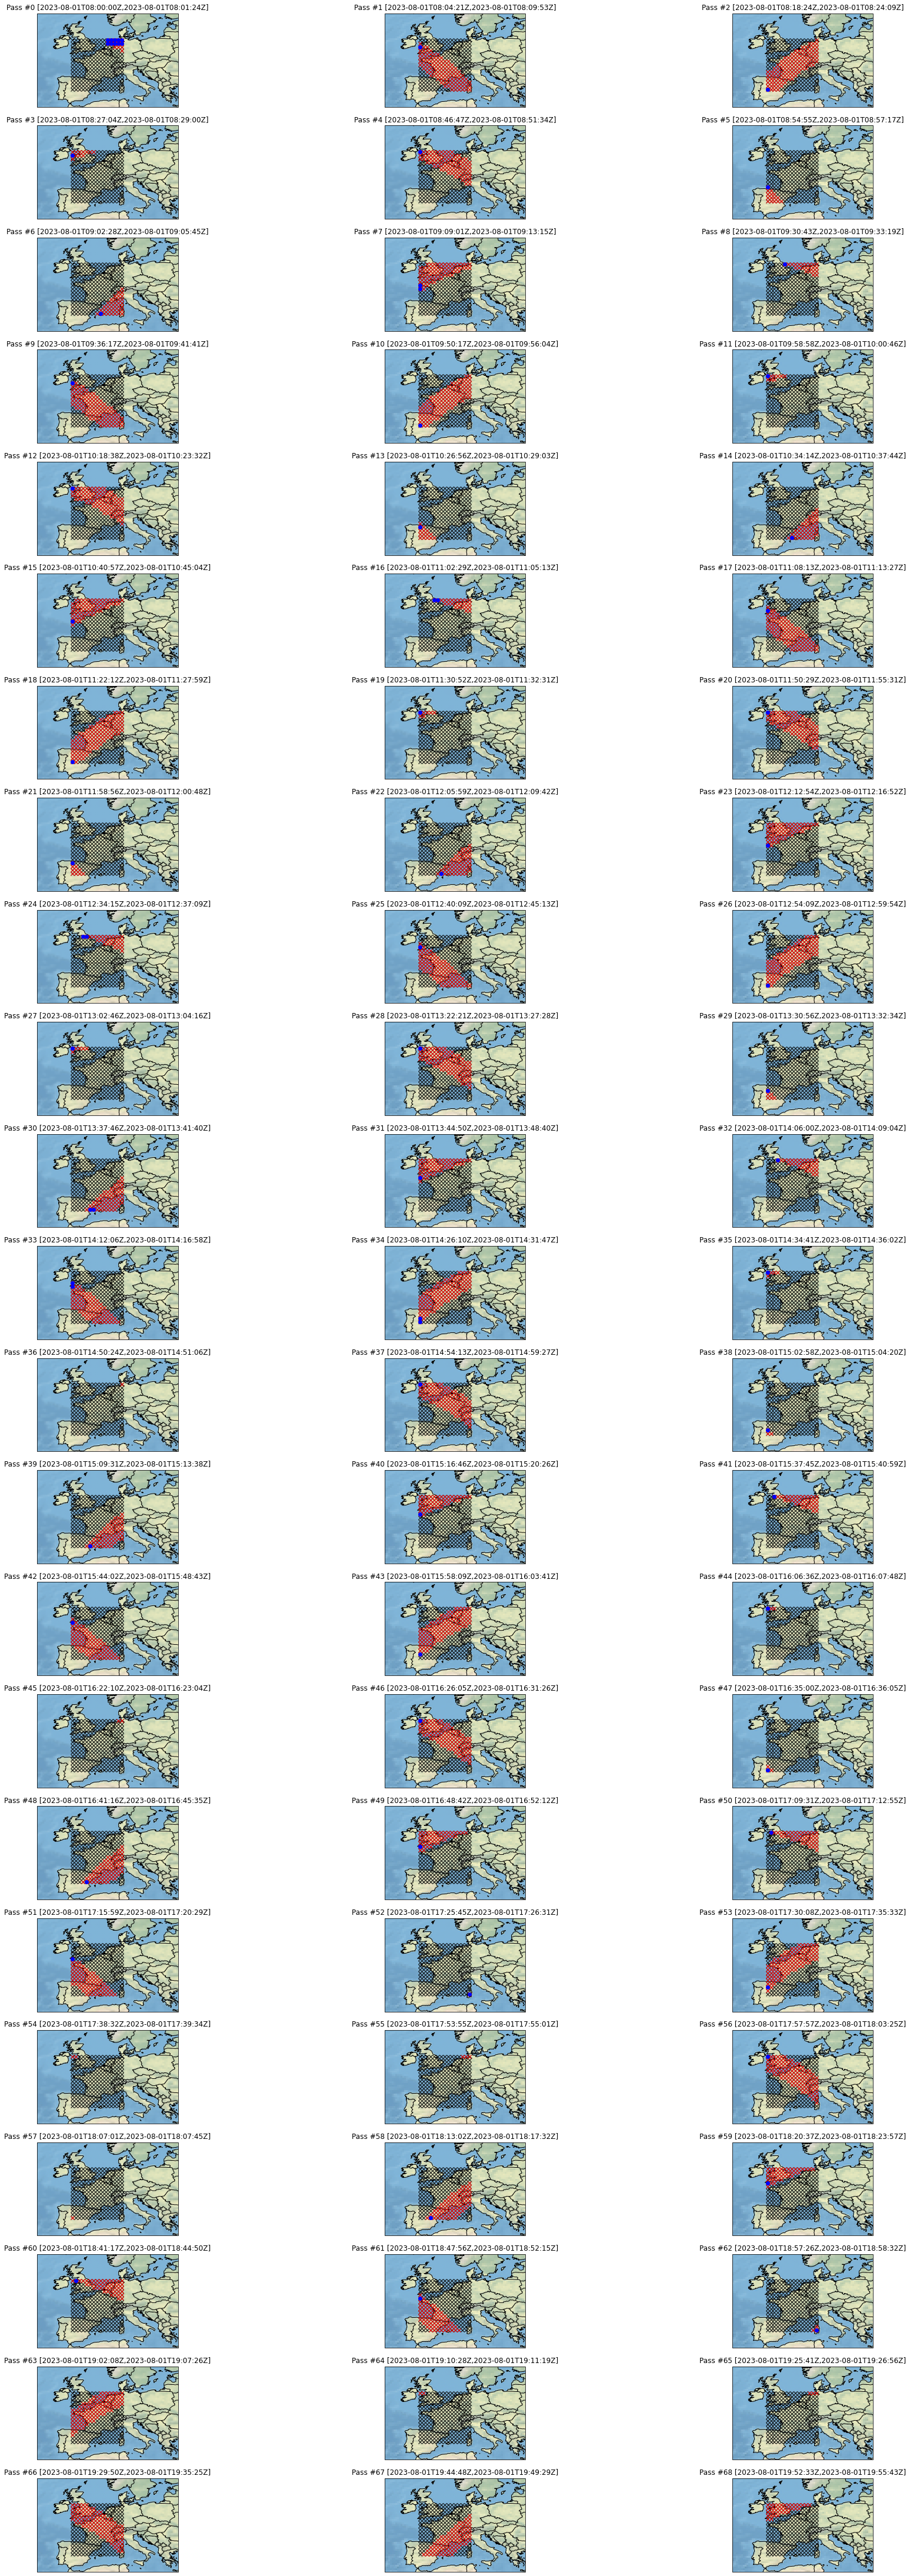

In [28]:
stage = 4
fileName = "data2"
alpha = 0.1

# Import the data
dataFile = open('data/{0}.json'.format(fileName))  
data = json.load(dataFile)

# Load data
obsRequests = data['ObservationRequests']
fixedPassCost = data['fixedPassCost']
minVisiDuration = data['minVisiDuration']
aois = data['AOIs']
accesses = data['Accesses']
referenceDate = data['referenceDate']
passCostPerTimeUnit = data['passCostPerTimeUnit']
goals = data['Goals']
satPasses = data['Passes']

# Lengths of lists
nAois = len(aois)
nObsRequests = len(obsRequests)
nPasses = len(satPasses)
nGoals = len(goals)

# Import the solution
if stage == 4:
    solutionFile = open("mySolutionStage4{0}Alpha{1}.json".format(fileName, int(alpha*100)))  
else:
    solutionFile = open("mySolutionStage{0}{1}.json".format(stage,fileName))  
solution = json.load(solutionFile)

# Reading of the solution
bookings = solution["Bookings"]
selectedPassIds = []
tStart = [0] * nPasses
tEnd = [0] * nPasses
for i in range(len(bookings)):
    selectedPassIds.append(bookings[i]['passId'])
    tStart[bookings[i]['passId']] = bookings[i]['bookingStart']
    tEnd[bookings[i]['passId']] = bookings[i]['bookingEnd']

# Computation of the total cost
timeUses = [tEnd[id] - tStart[id] for id in selectedPassIds]
totalCost = len(selectedPassIds)*data['fixedPassCost'] + sum(timeUses)*data['passCostPerTimeUnit']

# Computation of the quality of the covering: It is defined as the relation of the 
# requests covered over the total amount of requests
quality = 0
for aoiId in range(nAois):
    aux = 0
    for goalId in range(nGoals):
        for step in range(goals[goalId]['nSteps']):
            obsReqId = aoiId + nAois*aux + step + (goals[goalId]['nSteps'] - 1)*aoiId
            requestStart = step*goals[goalId]['duStep']
            requestEnd = step*goals[goalId]['duStep'] + goals[goalId]['rctHorizon']
            for passId in selectedPassIds:
                if any(accessIdObsReq in satPasses[passId]['accessIds'] for accessIdObsReq in obsRequests[obsReqId]['accessIds']):
                    #if (requestStart<=satPasses[passId]['end']-30) and (requestEnd>=satPasses[passId]['start']+30):
                    if (requestStart<=tEnd[passId]-30) and (requestEnd>=tStart[passId]+30):
                        quality +=1
                        break
        aux += goals[goalId]['nSteps']
        
quality /= nObsRequests

# Presentation of the results
print("IDs of the {0} selected passes: {1}".format(len(selectedPassIds), selectedPassIds))
print("Total cost of the covering: {0}".format(totalCost))
print("Quality of the covering: {0}".format(quality))

showSolution(data,solution)